In [1]:
from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks
from brax.io import html, mjcf, model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
from jax import vmap
import jax.random
from jax import lax

In [2]:
import distutils.util
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [5]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8" # 0.9 causes too much lag. 
from datetime import datetime
import functools

# Math
import jax.numpy as jp
import numpy as np
import jax
from jax import config # Analytical gradients work much better with double precision.
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGH)
from brax import math

# Sim
import mujoco
import mujoco.mjx as mjx

# Brax
from brax import envs
from brax.base import Motion, Transform
from brax.io import mjcf
from brax.envs.base import PipelineEnv, State
from brax.mjx.pipeline import _reformat_contact
from brax.training.acme import running_statistics
from brax.io import model

# Algorithms
# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks
from APGBRAX import train as apg
from APGBRAX import networks as apg_networks

from brax.training.agents.ppo import train as ppo

# Supporting
from etils import epath
import mediapy as media
import matplotlib.pyplot as plt
from ml_collections import config_dict
from typing import Any, Dict



In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [6]:
xml_path = epath.Path('anybotics_anymal_c/scene_mjx.xml').as_posix()

mj_model = mujoco.MjModel.from_xml_path(xml_path)

In [7]:


def cos_wave(t, step_period, scale):
    _cos_wave = -jp.cos(((2*jp.pi)/step_period)*t)
    return _cos_wave * (scale/2) + (scale/2)

def dcos_wave(t, step_period, scale):
    """ 
    Derivative of the cos wave, for reference velocity
    """
    return ((scale*jp.pi) / step_period) * jp.sin(((2*jp.pi)/step_period)*t)

def make_kinematic_ref(sinusoid, step_k, scale=0.3, dt=1/50):
    """ 
    Makes trotting kinematics for the 12 leg joints.
    step_k is the number of timesteps it takes to raise and lower a given foot.
    A gait cycle is 2 * step_k * dt seconds long.
    """
    
    _steps = jp.arange(step_k)
    step_period = step_k * dt
    t = _steps * dt
    
    wave = sinusoid(t, step_period, scale)
    # Commands for one step of an active front leg
    fleg_cmd_block = jp.concatenate(
        [jp.zeros((step_k, 1)),
        wave.reshape(step_k, 1),
        -2*wave.reshape(step_k, 1)],
        axis=1
    )
    # Our standing config reverses front and hind legs
    h_leg_cmd_bloc = -1 * fleg_cmd_block

    block1 = jp.concatenate([
        jp.zeros((step_k, 3)),
        fleg_cmd_block,
        h_leg_cmd_bloc,
        jp.zeros((step_k, 3))],
        axis=1
    )

    block2 = jp.concatenate([
        fleg_cmd_block,
        jp.zeros((step_k, 3)),
        jp.zeros((step_k, 3)),
        h_leg_cmd_bloc],
        axis=1
    )
    # In one step cycle, both pairs of active legs have inactive and active phases
    step_cycle = jp.concatenate([block1, block2], axis=0)
    return step_cycle



In [8]:
def get_config():
  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            scales=config_dict.ConfigDict(
              dict(
                min_reference_tracking = -2.5 * 3e-3, # to equalize the magnitude
                reference_tracking = -1.0,
                feet_height = -1.0
                )
              )
            )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(rewards=get_default_rewards_config(),))

  return default_config

# Math functions from (https://github.com/jiawei-ren/diffmimic)
def quaternion_to_matrix(quaternions):
    r, i, j, k = quaternions[..., 0], quaternions[..., 1], quaternions[..., 2], quaternions[..., 3]
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = jp.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
        ),
        -1,
    )
    return o.reshape(quaternions.shape[:-1] + (3, 3))

def matrix_to_rotation_6d(matrix):
    batch_dim = matrix.shape[:-2]
    return matrix[..., :2, :].reshape(batch_dim + (6,))

def quaternion_to_rotation_6d(quaternion):
    return matrix_to_rotation_6d(quaternion_to_matrix(quaternion))


In [9]:
class TrotAnymal(PipelineEnv):

  def __init__(
      self,
      termination_height: float=0.25,
      **kwargs,
  ):
    step_k = kwargs.pop('step_k', 25)

    physics_steps_per_control_step = 10
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)

    mj_model = mujoco.MjModel.from_xml_path(xml_path)
    kp = 230
    mj_model.actuator_gainprm[:, 0] = kp
    mj_model.actuator_biasprm[:, 1] = -kp

    sys = mjcf.load_model(mj_model)

    super().__init__(sys=sys, **kwargs)    
    
    self.termination_height = termination_height
    
    self._init_q = mj_model.keyframe('standing').qpos
    
    self.err_threshold = 0.4 # diffmimic; value from paper.
    
    self._default_ap_pose = mj_model.keyframe('standing').qpos[7:]
    self.reward_config = get_config()

    self.action_loc = self._default_ap_pose
    self.action_scale = jp.array([0.2, 0.8, 0.8] * 4)
    
    self.feet_inds = jp.array([21,28,35,42]) # LF, RF, LH, RH

    #### Imitation reference
    kinematic_ref_qpos = make_kinematic_ref(
      cos_wave, step_k, scale=0.3, dt=self.dt)
    kinematic_ref_qvel = make_kinematic_ref(
      dcos_wave, step_k, scale=0.3, dt=self.dt)
    
    self.l_cycle = jp.array(kinematic_ref_qpos.shape[0])
    
    # Expand to entire state space.

    kinematic_ref_qpos += self._default_ap_pose
    ref_qs = np.tile(self._init_q.reshape(1, 19), (self.l_cycle, 1))
    ref_qs[:, 7:] = kinematic_ref_qpos
    self.kinematic_ref_qpos = jp.array(ref_qs)
    
    ref_qvels = np.zeros((self.l_cycle, 18))
    ref_qvels[:, 6:] = kinematic_ref_qvel
    self.kinematic_ref_qvel = jp.array(ref_qvels)

    # Can decrease jit time and training wall-clock time significantly.
    self.pipeline_step = jax.checkpoint(self.pipeline_step, 
      policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
    
  def reset(self, rng: jax.Array) -> State:
    # Deterministic init

    qpos = jp.array(self._init_q)
    qvel = jp.zeros(18)
    
    data = self.pipeline_init(qpos, qvel)

    # Position onto ground
    pen = jp.min(data.contact.dist)
    qpos = qpos.at[2].set(qpos[2] - pen)
    data = self.pipeline_init(qpos, qvel)

    state_info = {
        'rng': rng,
        'steps': 0.0,
        'reward_tuple': {
            'reference_tracking': 0.0,
            'min_reference_tracking': 0.0,
            'feet_height': 0.0
        },
        'last_action': jp.zeros(12), # from MJX tutorial.
        'kinematic_ref': jp.zeros(19),
    }

    x, xd = data.x, data.xd
    obs = self._get_obs(data.qpos, x, xd, state_info)
    reward, done = jp.zeros(2)
    metrics = {}
    for k in state_info['reward_tuple']:
      metrics[k] = state_info['reward_tuple'][k]
    state = State(data, obs, reward, done, metrics, state_info)
    return jax.lax.stop_gradient(state)
  
  def step(self, state: State, action: jax.Array) -> State:
    action = jp.clip(action, -1, 1) # Raw action

    action = self.action_loc + (action * self.action_scale)

    data = self.pipeline_step(state.pipeline_state, action)
    
    # jax.debug.print('steps cycle: {}',state.info['steps']%self.l_cycle)
    # jax.debug.print('steps info: {}',state.info['steps'])
    
    
    ref_qpos = self.kinematic_ref_qpos[jp.array(state.info['steps']%self.l_cycle, int)]
    ref_qvel = self.kinematic_ref_qvel[jp.array(state.info['steps']%self.l_cycle, int)]
    
    # Calculate maximal coordinates
    ref_data = data.replace(qpos=ref_qpos, qvel=ref_qvel)
    ref_data = mjx.forward(self.sys, ref_data)
    ref_x, ref_xd = ref_data.x, ref_data.xd

    state.info['kinematic_ref'] = ref_qpos

    # observation data
    x, xd = data.x, data.xd
    obs = self._get_obs(data.qpos, x, xd, state.info)

    # Terminate if flipped over or fallen down.
    done = 0.0
    done = jp.where(x.pos[0, 2] < self.termination_height, 1.0, done)
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.where(jp.dot(math.rotate(up, x.rot[0]), up) < 0, 1.0, done)

    # reward
    reward_tuple = {
        'reference_tracking': (
          self._reward_reference_tracking(x, xd, ref_x, ref_xd)
          * self.reward_config.rewards.scales.reference_tracking
        ),
        'min_reference_tracking': (
          self._reward_min_reference_tracking(ref_qpos, ref_qvel, state)
          * self.reward_config.rewards.scales.min_reference_tracking
        ),
        'feet_height': (
          self._reward_feet_height(data.geom_xpos[self.feet_inds][:, 2]
                                   ,ref_data.geom_xpos[self.feet_inds][:, 2])
          * self.reward_config.rewards.scales.feet_height
        )
    }
    
    reward = sum(reward_tuple.values())

    # state management
    state.info['reward_tuple'] = reward_tuple
    state.info['last_action'] = action # used for observation. 

    for k in state.info['reward_tuple'].keys():
      state.metrics[k] = state.info['reward_tuple'][k]

    state = state.replace(
        pipeline_state=data, obs=obs, reward=reward,
        done=done)
    
    #### Reset state to reference if it gets too far
    error = (((x.pos - ref_x.pos) ** 2).sum(-1)**0.5).mean()
    to_reference = jp.where(error > self.err_threshold, 1.0, 0.0)

    to_reference = jp.array(to_reference, dtype=int) # keeps output types same as input. 
    ref_data = self.mjx_to_brax(ref_data)

    data = jax.tree_util.tree_map(lambda x, y: 
                                  jp.array((1-to_reference)*x + to_reference*y, x.dtype), data, ref_data)
    
    x, xd = data.x, data.xd # Data may have changed.
    obs = self._get_obs(data.qpos, x, xd, state.info)
    
    return state.replace(pipeline_state=data, obs=obs)
    
  def _get_obs(self, qpos: jax.Array, x: Transform, xd: Motion,
               state_info: Dict[str, Any]) -> jax.Array:

    inv_base_orientation = math.quat_inv(x.rot[0])
    local_rpyrate = math.rotate(xd.ang[0], inv_base_orientation)

    obs_list = []
    # yaw rate
    obs_list.append(jp.array([local_rpyrate[2]]) * 0.25)
    # projected gravity
    obs_list.append(
        math.rotate(jp.array([0.0, 0.0, -1.0]), inv_base_orientation))
    # motor angles
    angles = qpos[7:19]
    obs_list.append(angles - self._default_ap_pose)
    # last action
    obs_list.append(state_info['last_action'])
    # kinematic reference
    kin_ref = self.kinematic_ref_qpos[jp.array(state_info['steps']%self.l_cycle, int)]
    obs_list.append(kin_ref[7:]) # First 7 indicies are fixed

    obs = jp.clip(jp.concatenate(obs_list), -100.0, 100.0)

    return obs
  
  def mjx_to_brax(self, data):
    """ 
    Apply the brax wrapper on the core MJX data structure.
    """
    q, qd = data.qpos, data.qvel
    x = Transform(pos=data.xpos[1:], rot=data.xquat[1:])
    cvel = Motion(vel=data.cvel[1:, 3:], ang=data.cvel[1:, :3])
    offset = data.xpos[1:, :] - data.subtree_com[self.sys.body_rootid[1:]]
    offset = Transform.create(pos=offset)
    xd = offset.vmap().do(cvel)
    data = _reformat_contact(self.sys, data)
    return data.replace(q=q, qd=qd, x=x, xd=xd)


  # ------------ reward functions----------------
  def _reward_reference_tracking(self, x, xd, ref_x, ref_xd):
    """
    Rewards based on inertial-frame body positions.
    Notably, we use a high-dimension representation of orientation.
    """

    f = lambda x, y: ((x - y) ** 2).sum(-1).mean()

    _mse_pos = f(x.pos,  ref_x.pos)
    _mse_rot = f(quaternion_to_rotation_6d(x.rot),
                 quaternion_to_rotation_6d(ref_x.rot))
    _mse_vel = f(xd.vel, ref_xd.vel)
    _mse_ang = f(xd.ang, ref_xd.ang)

    # Tuned to be about the same size.
    return _mse_pos      \
      + 0.1 * _mse_rot   \
      + 0.01 * _mse_vel  \
      + 0.001 * _mse_ang

  def _reward_min_reference_tracking(self, ref_qpos, ref_qvel, state):
    """ 
    Using minimal coordinates. Improves accuracy of joint angle tracking.
    """
    pos = jp.concatenate([
      state.pipeline_state.qpos[:3],
      state.pipeline_state.qpos[7:]])
    pos_targ = jp.concatenate([
      ref_qpos[:3],
      ref_qpos[7:]])
    pos_err = jp.linalg.norm(pos_targ - pos)
    vel_err = jp.linalg.norm(state.pipeline_state.qvel- ref_qvel)

    return pos_err + vel_err

  def _reward_feet_height(self, feet_pos, feet_pos_ref):
    return jp.sum(jp.abs(feet_pos - feet_pos_ref)) # try to drive it to 0 using the l1 norm.

envs.register_environment('trotting_anymal', TrotAnymal)

In [11]:
env = envs.get_environment("trotting_anymal", step_k = 13)
eval_env = envs.get_environment("trotting_anymal", step_k = 13)

env.sys.opt

Option(timestep=Array(0.002, dtype=float64, weak_type=True), impratio=Array(100., dtype=float64, weak_type=True), tolerance=Array(1.e-08, dtype=float64, weak_type=True), ls_tolerance=Array(0.01, dtype=float64, weak_type=True), gravity=Array([ 0.  ,  0.  , -9.81], dtype=float64), wind=Array([0., 0., 0.], dtype=float64), density=Array(0., dtype=float64, weak_type=True), viscosity=Array(0., dtype=float64, weak_type=True), has_fluid_params=False, integrator=<IntegratorType.EULER: 0>, cone=<ConeType.PYRAMIDAL: 0>, jacobian=<JacobianType.AUTO: 2>, solver=<SolverType.NEWTON: 2>, iterations=1, ls_iterations=6, disableflags=<DisableBit.EULERDAMP: 16384>)

In [12]:
env.sys.actuator

Actuator(q_id=Array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18], dtype=int32), qd_id=Array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17], dtype=int32), ctrl_range=Array([[-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28],
       [-6.28,  6.28]], dtype=float64), force_range=Array([[-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.],
       [-80.,  80.]], dtype=float64), gain=Array([230., 230., 230., 230., 230., 230., 230., 230., 230., 230., 230.,
       230.], dtype=float64), gear=Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64), bias_q=Array([-230., -230., -230., -230., -230., -230., -230., -230., 

In [13]:
print(env.dt)
print(env.sys.opt)

0.02
Option(timestep=Array(0.002, dtype=float64, weak_type=True), impratio=Array(100., dtype=float64, weak_type=True), tolerance=Array(1.e-08, dtype=float64, weak_type=True), ls_tolerance=Array(0.01, dtype=float64, weak_type=True), gravity=Array([ 0.  ,  0.  , -9.81], dtype=float64), wind=Array([0., 0., 0.], dtype=float64), density=Array(0., dtype=float64, weak_type=True), viscosity=Array(0., dtype=float64, weak_type=True), has_fluid_params=False, integrator=<IntegratorType.EULER: 0>, cone=<ConeType.PYRAMIDAL: 0>, jacobian=<JacobianType.AUTO: 2>, solver=<SolverType.NEWTON: 2>, iterations=1, ls_iterations=6, disableflags=<DisableBit.EULERDAMP: 16384>)


In [9]:
# train_fn = functools.partial(
#     ppo.train, num_timesteps=10_000_000, num_evals=10, reward_scaling=0.1,
#     episode_length=1000, normalize_observations=True, action_repeat=1,
#     unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
#     discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=1024,
#     batch_size=1024, seed=0)

# x_data = []
# y_data = []
# ydataerr = []
# env = envs.get_environment("trotting_anymal", step_k = 13)

# def progress(num_steps, metrics):
#   x_data.append(num_steps)
#   y_data.append(metrics['eval/episode_reward'])
#   ydataerr.append(metrics['eval/episode_reward_std'])

# make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

# plt.errorbar(x_data, y_data, yerr=ydataerr)
# plt.xlabel('# environment steps')
# plt.ylabel('reward per episode')

In [14]:
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks,
    hidden_layer_sizes=(256, 128)
)

epochs = 499


train_fn = functools.partial(apg.train,
                             episode_length=1000,
                             policy_updates=epochs,
                             horizon_length=32,
                             num_envs=64,
                             learning_rate=1.5e-4,
                             schedule_decay=0.995,
                             num_eval_envs=64,
                             num_evals=10 + 1,
                             use_float64=True,
                             normalize_observations=True,
                             network_factory=make_networks_factory)

before metrics


/tmp/ipykernel_3574/966135583.py:15: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, it* 1.25])


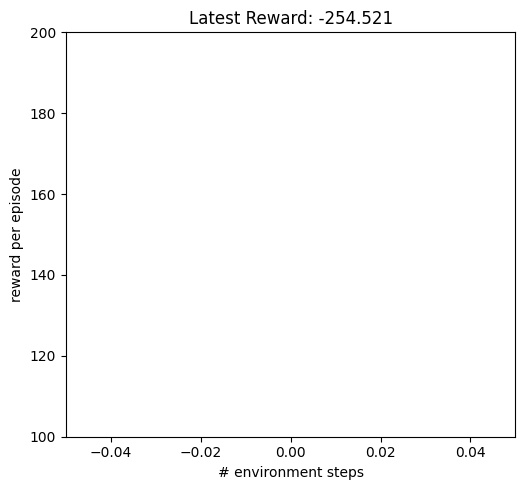

after metrics
after scramble time
it 0
before epoch
reached the minibatch step:{} 1
loss
after f
env step
Actions: {} Traced<ShapedArray(float64[64,12])>with<DynamicJaxprTrace(level=4/1)>
New state obs: {} Traced<ShapedArray(float64[64,40])>with<DynamicJaxprTrace(level=4/1)>
after loss
after the minibatch_step
jax trainng epoch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1
reached the minibatch step:1
loss3
sssf3
env step3
sssloss3
after the minibatch step:1


In [15]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

def progress(it, metrics):
  times.append(datetime.now())
  x_data.append(it)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  #y_pose_error.append(metrics['eval/episode_pose_error'])  # capture pose error
  
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1) 
  plt.xlim([0, it* 1.25])
  plt.ylim([100, 200])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'Latest Reward: {y_data[-1]:.3f}')
  plt.plot(x_data, y_data, '-o')
  
  plt.tight_layout()
  plt.show()
  

# Each foot contacts the ground twice/sec.
env = envs.get_environment("trotting_anymal", step_k = 13)
eval_env = envs.get_environment("trotting_anymal", step_k = 13)

make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)
